This notebook is developed using `ml.t3.medium` instance with `Python 3 (Data Science)` kernel on SageMaker Studio.

In [ ]:
!pip install -q nibabel nilearn
!apt update
!apt install zip

In [ ]:
import os
import glob
import time
import boto3
import sagemaker
import numpy as np
import nibabel as nib
from nilearn import plotting, image
from itertools import islice
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
boto_session = boto3.Session(region_name=region)
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket = sagemaker_session.default_bucket()

dataset_prefix = 'medical-imaging-workshop/dataset'
scaled_dataset_prefix = 'medical-imaging-workshop/scaled_dataset'
scaled_zipped_dataset_prefix = 'medical-imaging-workshop/scaled_zipped_dataset'

%matplotlib inline
t0 = time.time()

### The BraTS dataset
We use a multi-modal MRI brain tumor image segmentation benchmark dataset named BraTS. There are 750 patients (484 training and 266 testing) from BraTS’16 and ’17. This dataset is provided by [Medical Segmentation Decathlon](http://medicaldecathlon.com/), and can be downloaded from the [AWS Open Data Registry](https://registry.opendata.aws/msd/).

In [ ]:
!mkdir ./dataset/
!aws s3 cp --no-sign-request s3://msd-for-monai/Task01_BrainTumour.tar ./dataset/Task01_BrainTumour.tar

Unpack the dataset tar archive

In [ ]:
!tar xvf ./dataset/Task01_BrainTumour.tar -C ./dataset/

Write data to your S3

In [ ]:
!aws s3 sync ./dataset/Task01_BrainTumour/ s3://{bucket}/{dataset_prefix}/Task01_BrainTumour/

In [ ]:
!aws s3 ls s3://{bucket}/{dataset_prefix}/Task01_BrainTumour/

### Exploration
Let's take a look at a sample image/label set. Firstly, the NIfTI images are loaded with `Nibabel`. 

In [ ]:
nii = nib.load('dataset/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz')
seg = nib.load('dataset/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz')
print(nii)

We can plot the MRI images and the corresponding tumor labels using `nilearn` library. The MRI imaging sequences included in this dataset are T2-FLAIR, T1, T1Gd, and T2-weighted (top to bottom in the left panel in the figure below). The four modalities are concatenated as the fourth dimension (channel) on top of the X, Y, and Z dimensions. The target of this dataset is to segment gliomas tumors and subregions. The tumor can also be partitioned as peritumoral edema, GD-enhancing tumor, and the necrotic (or non-enhancing) tumor core (overlayed in the right panel in the figure below). The tumor can also be delineated as a whole tumor (WT), tumor core (TC), and enhancing tumor (ET), which is the label definition we used in this work. Human expert annotation is conducted and provided within the dataset.

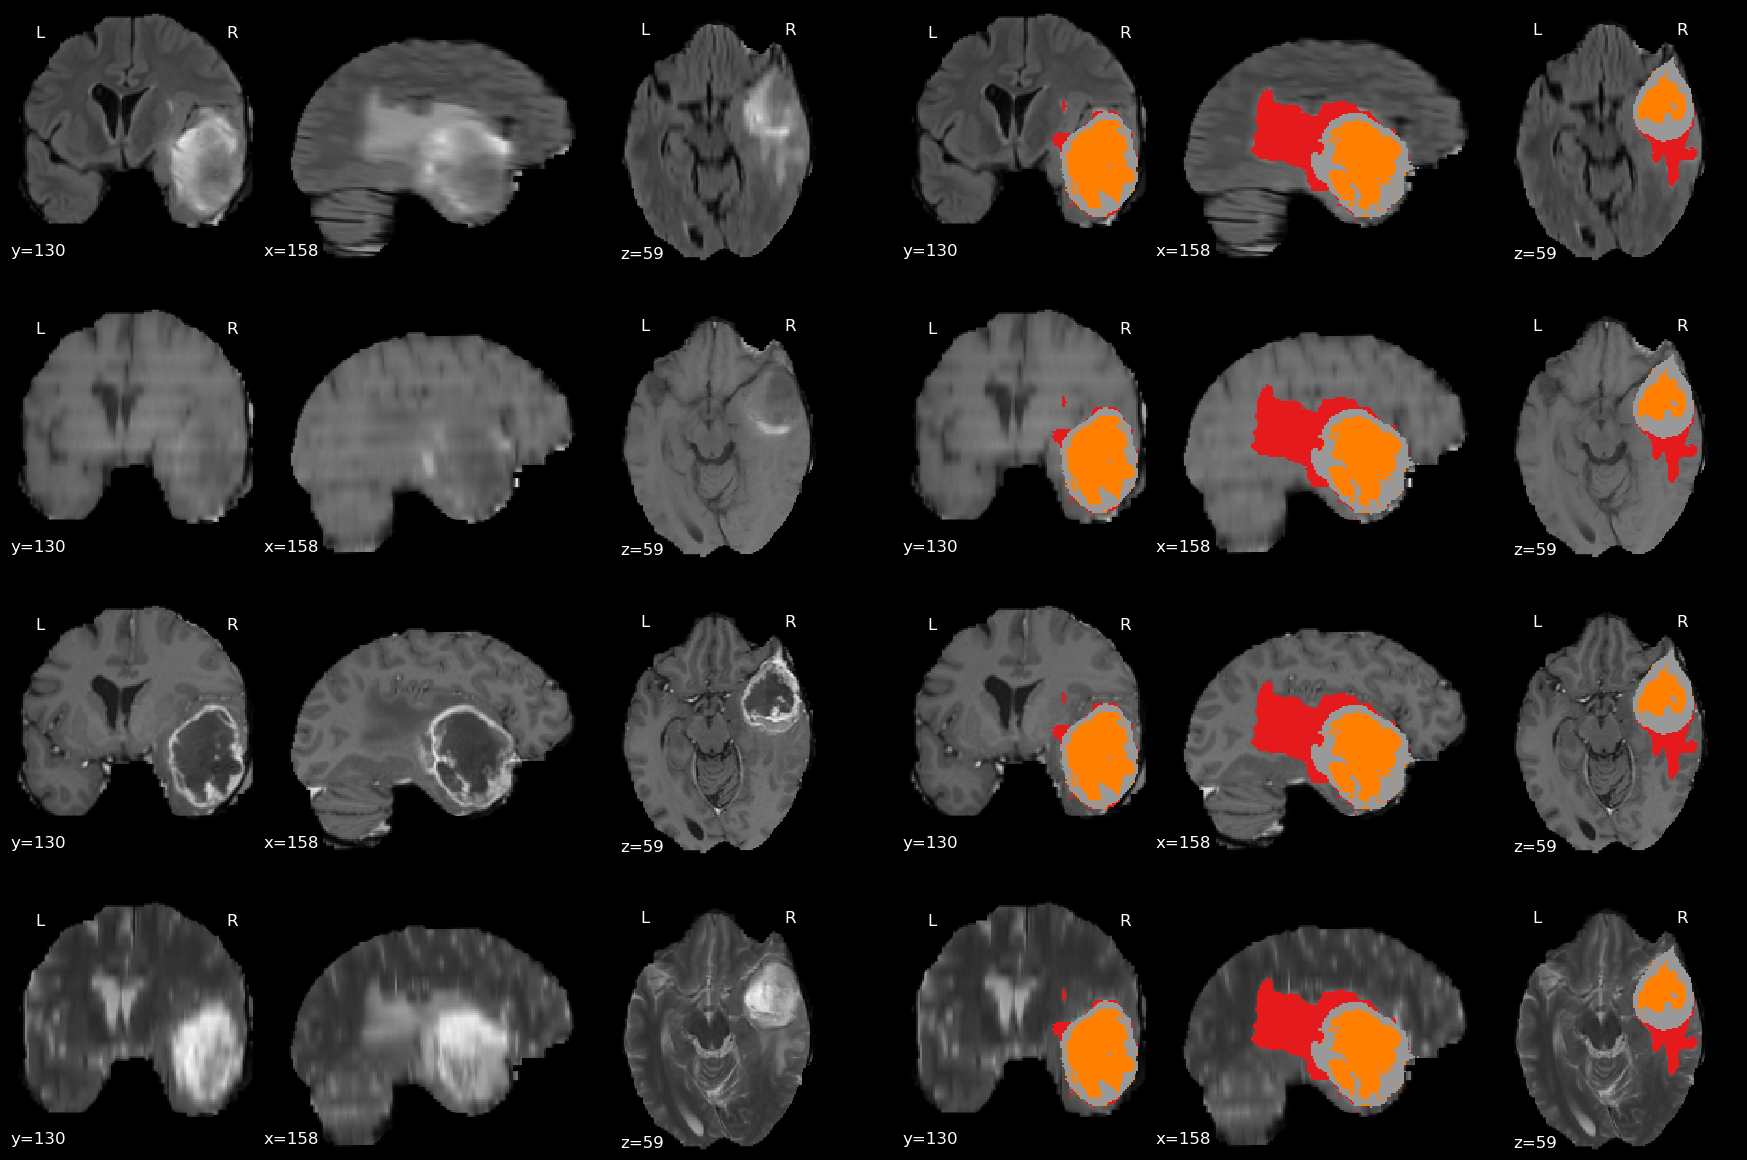

In [7]:
niis_by_channel = [image.index_img(nii, i) for i in range(nii.shape[-1])]

f, ax = plt.subplots(4,2, figsize=(18,12), facecolor=(0, 0, 0))
f.tight_layout()

for i in range(len(niis_by_channel)):
    plotting.plot_roi(seg, bg_img=niis_by_channel[i], figure=f, axes=ax[i][0], 
                      alpha = 0, dim=0, draw_cross = False
                     )
    plotting.plot_roi(seg, bg_img=niis_by_channel[i], figure=f, axes=ax[i][1], 
                      alpha = 1, cmap = 'Set1', dim=0, draw_cross = False
                     )
#f.savefig('./datasets/BRATS_001_fig.png', dpi=150, facecolor=(0, 0, 0))

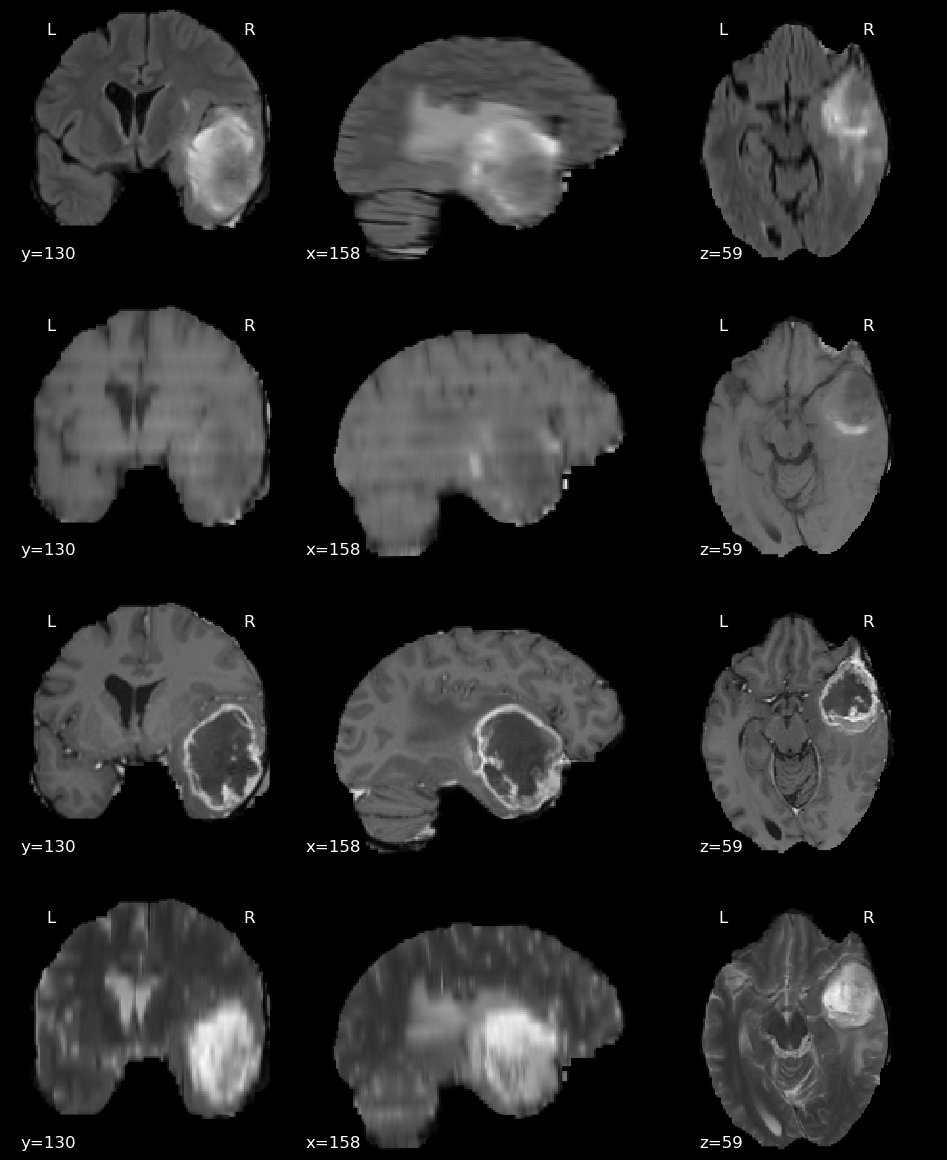

In [9]:
f, ax = plt.subplots(4,1, figsize=(10,12), facecolor=(0, 0, 0))
f.tight_layout()
for i in range(len(niis_by_channel)):
    plotting.plot_roi(seg, bg_img=niis_by_channel[i], figure=f, axes=ax[i], 
                      alpha = 0, dim=0, draw_cross = False
                     )

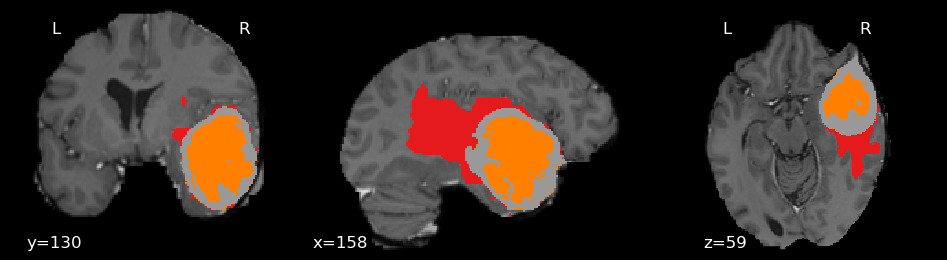

In [10]:
f, ax = plt.subplots(1,1, figsize=(10, 3), facecolor=(0, 0, 0))
f.tight_layout()
plotting.plot_roi(seg, bg_img=niis_by_channel[2], figure=f, axes=ax,
                  alpha = 1, cmap = 'Set1', dim=0, draw_cross = False
                 )

Let's move on to start training models using MONAI and Amazon SageMaker in [01-model_training.ipynb](./01-model_training.ipynb)